# Population density

## Download and unzip data

Source: https://ghsl.jrc.ec.europa.eu/ghs_pop2019.php

In [2]:
from urllib import request
from os import path
from zipfile import ZipFile

URL_TEMPLATE = 'https://cidportal.jrc.ec.europa.eu/'\
             + 'ftp/jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/GHS_POP_E2015_GLOBE_R2019A_54009_250/'\
             + 'V1-0/tiles/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_{tile}.zip'
FILE_TEMPLATE = 'GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_{tile}.tif'
TILES = [
    '18_1', '19_1', '20_1',
    '18_2', '19_2', '20_2',
]
DATA_DIR = 'data'

urls = [URL_TEMPLATE.format(tile = t) for t in TILES]
zip_dsts = [path.join(DATA_DIR, 'compressed', t + '.zip') for t in TILES]
zipped_paths = [FILE_TEMPLATE.format(tile = t) for t in TILES]
tif_dsts = [path.join(DATA_DIR, t + '.tif') for t in TILES]

for url, zip_dst, ds_path, tif_dst in zip(urls, zip_dsts, zipped_paths, tif_dsts):
    if path.exists(tif_dst):
        print(f'{tif_dst} already exists!')
        continue
    if not path.exists(zip_dst):
        res = request.urlopen(url)
        with open(zip_dst, 'wb') as zf:
            zf.write(res.read())
    with ZipFile(zip_dst).open(ds_path, 'r') as ds:
        with open(tif_dst, 'wb') as dst:
            dst.write(ds.read())
print('Done!')

Done!


## Transform raw data

The source data is divided to a bunch of tiles that we'll want to combine.

In [27]:
import georasters as gr

COMBINED_DST = path.join(DATA_DIR, 'popdensity')

data = [gr.from_file(tif) for tif in tif_dsts]
result = gr.merge(data)

result.to_tiff(COMBINED_DST) # georasters adds the file extension for us

## Some description of the data

In [39]:
gr.get_geo_info(COMBINED_DST + '.tif')

(-200.0,
 12000,
 8000,
 (-41000.0, 250.0, 0.0, 8000000.0, 0.0, -250.0),
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x000001CA8D69FB70> >,
 'Float32')

In [43]:
result.projection.ExportToWkt()

'PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [24]:
result.median()

0.0

In [25]:
result.mean()

3.173619462202861

In [28]:
result.max()

57538.125

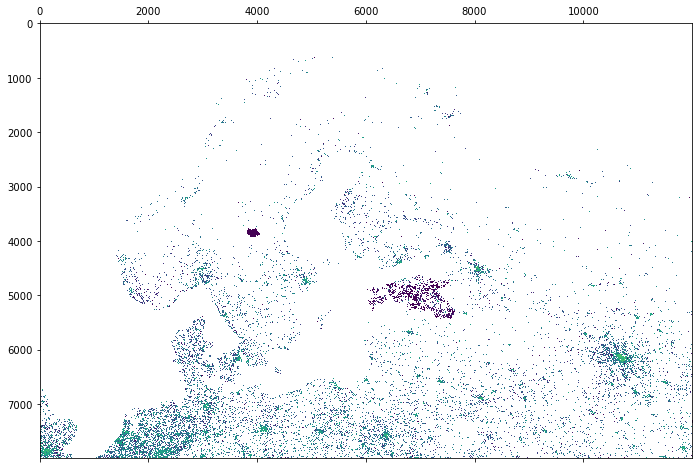

In [38]:
import matplotlib.colors as clrs

normalizer = clrs.LogNorm(vmin = .01, vmax = result.max())
result.plot(figsize = (12, 8), norm = normalizer)

## Mapping the data between formats

`to_latlon` and `from_latlon` can be used to map between the source format and latitude/longitude.
In addition to this, you'll need to use the `georasters` `map_pixel` to actually access the correct raster location
using the coordinates.

In [49]:
from pyproj import CRS, Transformer

crs_source = CRS.from_wkt(result.projection.ExportToWkt())
crs_latlon = CRS.from_epsg(4326)
transformer_to_latlon = Transformer.from_crs(crs_source, crs_latlon)
transformer_from_latlon = Transformer.from_crs(crs_latlon, crs_source)

def to_latlon(north, east): return transformer_to_latlon.transform(north, east)
def from_latlon(lat, lon): return transformer_from_latlon.transform(lat, lon)

result.map_pixel(*from_latlon(60.1717794, 24.9413548)) # Helsinki railway station coordinates

547.9605102539062

The resolution of our data is 250m,
and [Helsinki urban density $1800/km^2$, metro density $500/km^2$](https://en.wikipedia.org/wiki/Helsinki),
so this result looks valid enough

In [57]:
import numpy as np
row, col = np.unravel_index(result.argmax(), result.shape)
geot = result.geot
source_coords = gr.map_pixel_inv(row, col, geot[1], geot[-1], geot[0], geot[3])
to_latlon(*source_coords)

(21.343238104222984, 69.67228731788535)

Our highest pop density is apparently somewhere near Moscow.
An error in the data perhaps, we might want to clean this up!